In [1]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import importlib

from utils import load_imagenat
importlib.reload(load_imagenat)

%matplotlib inline

In [2]:
### loading imagenat data ###
data_train, data_test, label_train, label_test = load_imagenat.load_data('imagenat')

Done
Extracting training data...
Extracting test data...
Done


In [3]:
### set parts of data to unlabeled data. label 0 means corresponding sample is not assigned any label ###
np.random.seed(10)
label = np.copy(label_train)

from utils import get_unlabeled
importlib.reload(get_unlabeled)
unlabeled_ind = get_unlabeled.get_unlabeled(data_train, label_train)
label[unlabeled_ind==1] = 0
print('Unique labels : %s \nNumber of samples : %s\nData dimension : %s'%(np.unique(label), data_train.shape[0], data_train.shape[1]))

Unique labels : [0 3 8] 
Number of samples : 500
Data dimension : 2


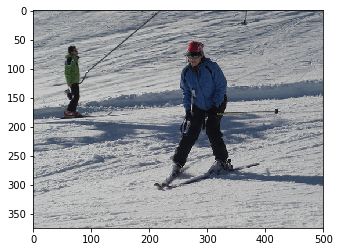

In [4]:
### Please note below image is not relevant to this hands-on ###
img=mpimg.imread('./test_images/ILSVRC2012_val_00046368.JPEG')
plt.imshow(img)

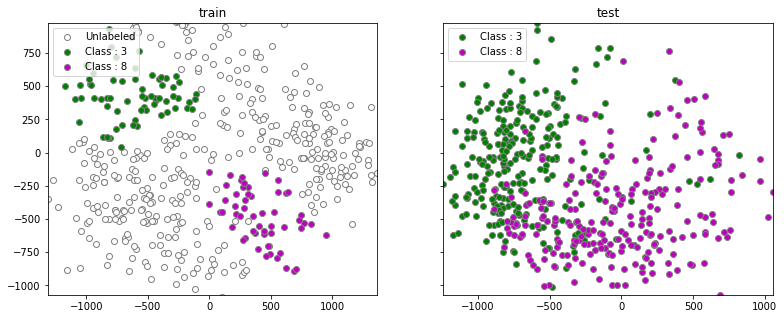

In [5]:
### plot data ###
def plot_data(data1, data2=None, model=None):
    def plot(ax, data, mode, model):
        X, y = data
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        unique = np.sort(np.unique(y))
        cnt = 0
        for u in unique:
            if u == 0:
                label = "Unlabeled"
                color = "w"
            else:
                label = "Class : %s"%u
                color = ["g", "m"][cnt]
                cnt += 1
            ax.scatter(X[y==u][:, 0], X[y==u][:, 1], label=label, color=color , edgecolor='0.5')
        if model is not None:
            w = model.coef_
            b = model.intercept_
            x_axis = np.arange(x_min, x_max, 0.1)
            y_axis = (-b[0] - w[0, 0]*x_axis) /w[0, 1]
            ax.plot(x_axis, y_axis, color="b")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_title(mode)
        ax.legend(loc='upper left')
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))
    for ax, data, mode in zip([ax1, ax2], [data1, data2], ['train', 'test']):
        plot(ax, data, mode, model)

plot_data([data_train, label], [data_test, label_test])

In [6]:
### load a Deep Neural Network model and train its parameters with only labeled data###
from utils.models import VeryDeepNeuralNetwork 
model1 = VeryDeepNeuralNetwork()
model1.fit(data_train[unlabeled_ind!=1], label_train[unlabeled_ind!=1])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

ACC : 0.736000


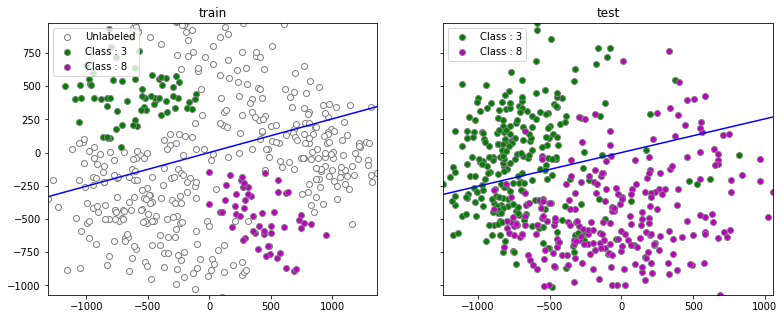

In [7]:
### visualize learned parameters ###
from sklearn.metrics import accuracy_score
acc1 = accuracy_score(label_test, model1.predict(data_test))
plot_data([data_train, label], [data_test, label_test], model1)
print("ACC : %f"%acc1)

In [8]:
""" TODO 
Implement you semi-supervised method below.
You can use below functions:

- model.fit(X, y, sample_weight) : train a classifier 

- model.predict_proba(X) 
   output :  N x C matrix whose ij-th element indicates the probability p(c_j | x_i) 
   
-model.predict(X)  
   output : N vector whose i-th element indicates the predicted class.

For more information, refer http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
"""

alpha = 1.0
model2 = VeryDeepNeuralNetwork()
sample_weight = np.ones(data_train.shape[0])
sample_weight[unlabeled_ind_copy==1] = alpha

for i in range(10):
    unlabeled_ind_copy = unlabeled_ind[:]
    if i > 0:
        pseudo_label = model2.predict(data_train)
        prob = model2.predict_proba(data_train)
        prob = np.max(prob, axis=1)
        pseudo_label[unlabeled_ind_copy!=1] = label_train[unlabeled_ind_copy!=1]
        unlabeled_ind_copy[prob > 0.90] = 0
    else:
        pseudo_label = label[:]

    model2.fit(data_train[unlabeled_ind_copy!=1], pseudo_label[unlabeled_ind_copy!=1], sample_weight[unlabeled_ind_copy!=1])

acc2 = accuracy_score(label_test, model2.predict(data_test))
print("Without unlabeled data (above)\n ACC : %f \n"%acc1)
print("With unlabeled data (below) \n ACC : %f"%acc2)
plot_data([data_train, label], [data_test, label_test], model1)
plot_data([data_train, label], [data_test, label_test], model2)

NameError: name 'unlabeled_ind_copy' is not defined